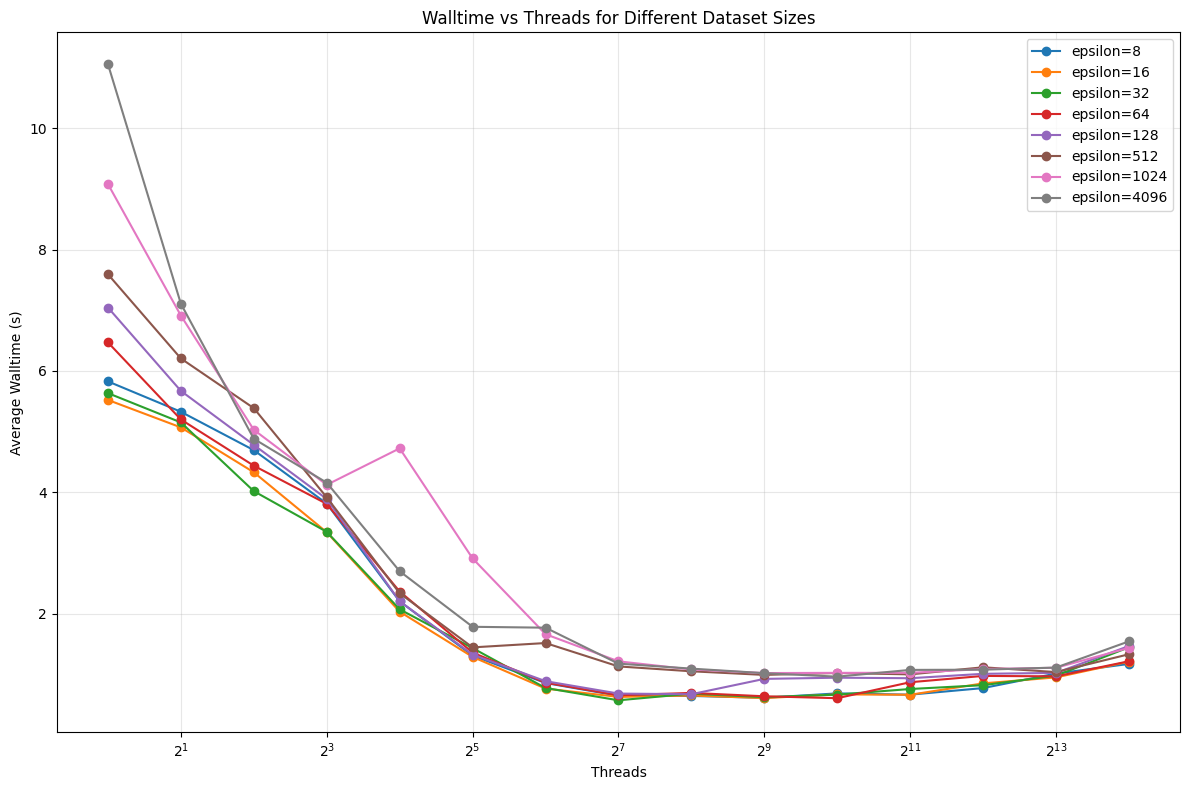

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    df = pd.read_csv(file_path)
    return df['threads'], df['avg_walltime_s']

# 文件名模式
file_patterns = ['8_falcon_multithread.csv', '16_falcon_multithread.csv', '32_falcon_multithread.csv',
                 '64_falcon_multithread.csv', '128_falcon_multithread.csv', '512_falcon_multithread.csv',
                 '1024_falcon_multithread.csv', '4096_falcon_multithread.csv']

# 创建图表
plt.figure(figsize=(12, 8))

# 为每个文件绘制一条线
for file_pattern in file_patterns:
    try:
        # 提取文件前缀作为标签
        label = file_pattern.split('_')[0]
        threads, avg_walltime_s = load_data(file_pattern)
        plt.plot(threads, avg_walltime_s, marker='o', label=f'epsilon={label}')
    except FileNotFoundError:
        print(f"文件 {file_pattern} 未找到，跳过")
        continue

# 设置图表属性
plt.xlabel('Threads')
plt.ylabel('Average Walltime (s)')
plt.title('Walltime vs Threads for Different Dataset Sizes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)  # 使用对数刻度，基数为2
# plt.yscale('log', base=10)  # 使用对数刻度

# 显示图表
plt.tight_layout()
plt.show()

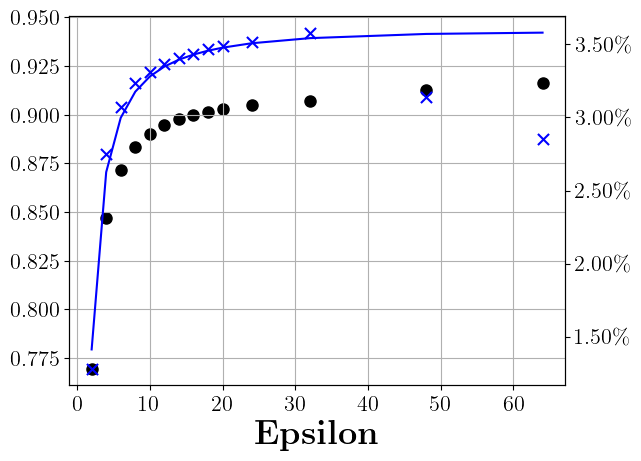

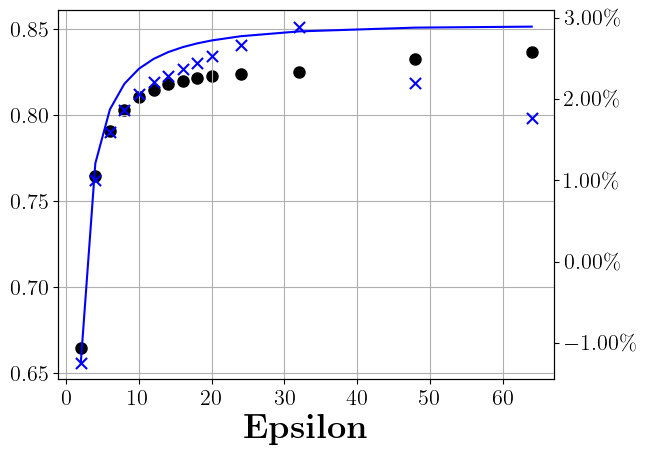

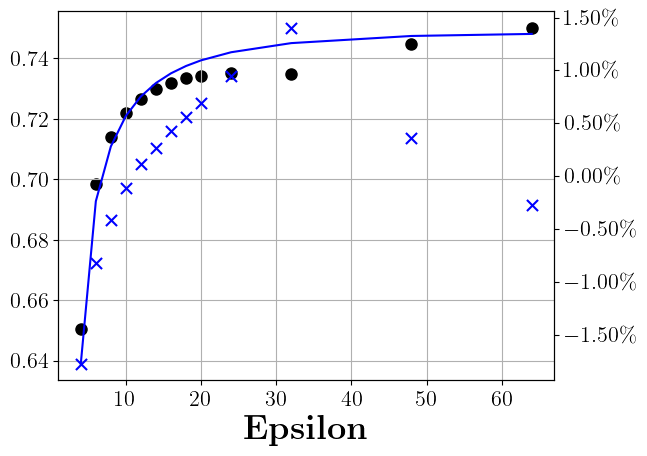

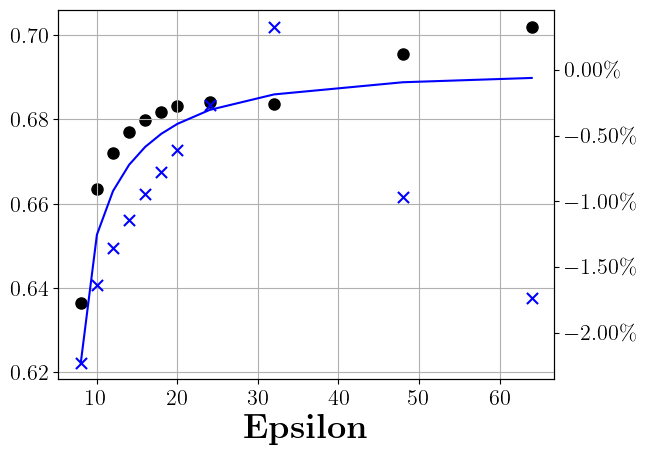

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

LOG_PATH = "/mnt/home/zwshi/learned-index/cost-model/visualize/data/log/"
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

def load_data(file_path,max_eps=64):
    df = pd.read_csv(file_path)
    grouped = df.groupby('epsilon', as_index=False)['hit_ratio'].mean()
    grouped = grouped.rename(columns={'hit_ratio': 'real'})
    grouped = grouped[grouped["epsilon"]<=max_eps] 
    return grouped

def load_log(log_file_path, M=20, query_nums=1e6, max_eps=64):
    df = pd.read_csv(log_file_path)
    df = df[df['M'] == M]
    grouped = df.groupby('epsilon', as_index=False)['ratio'].mean()
    grouped['expected'] = grouped['ratio']
    grouped = grouped[grouped["epsilon"] <= max_eps]
    return grouped[['epsilon', 'expected']] 

def prepare_merged(file_path, log_file_path, M=20, query_nums=1e6):
    real_df = load_data(file_path)
    # print(real_df)
    exp_df  = load_log(log_file_path, M, query_nums)
    # print(exp_df)
    merged = pd.merge(real_df, exp_df, on='epsilon', how='inner').sort_values('epsilon')
    merged['rel_err'] = (merged['expected'] - merged['real']) / merged['real']
    return merged

# === 新增：预计算全局 y 轴范围（左轴：IO；右轴：相对误差%）===
def compute_global_limits(tasks, log_file_path, query_nums=1e6, max_eps=64, pad_ratio=0.05):
    """
    tasks: [(csv_path, M), (csv_path, M), ...]
    返回： (y_io_min, y_io_max), (y_err_min_pct, y_err_max_pct)
    """
    io_min, io_max = float('inf'), float('-inf')
    err_min, err_max = float('inf'), float('-inf')
    for csv_path, M in tasks:
        merged = prepare_merged(csv_path, log_file_path, M, query_nums)
        if len(merged)==0: 
            continue
        # 左轴：真实/预测 hit_ratio
        cur_min = min(merged['real'].min(), merged['expected'].min())
        cur_max = max(merged['real'].max(), merged['expected'].max())
        io_min = min(io_min, cur_min)
        io_max = max(io_max, cur_max)
        # 右轴：相对误差（转百分比）
        cur_e_min = (merged['rel_err']*100).min()
        cur_e_max = (merged['rel_err']*100).max()
        err_min = min(err_min, cur_e_min)
        err_max = max(err_max, cur_e_max)
    # 加一点边距，避免顶边
    io_pad  = (io_max-io_min)*pad_ratio if np.isfinite(io_min) and np.isfinite(io_max) else 0
    err_pad = (err_max-err_min)*pad_ratio if np.isfinite(err_min) and np.isfinite(err_max) else 0
    return (io_min-io_pad, io_max+io_pad), (err_min-err_pad, err_max+err_pad)

def plot_data(file_path, log_file_path, revision_log_path, M=20, query_nums=1e6,
              y_io_lim=None, y_err_lim_pct=None):
    merged = prepare_merged(file_path, log_file_path, M, query_nums)
    # revi = prepare_merged(file_path, revision_log_path, M, query_nums)
    fig, ax = plt.subplots()
    ax.scatter(merged['epsilon'], merged['real'], marker='o',
               label=r'\textbf{\Large{Real Hit Ratio}}', color="black")
    ax.plot(merged['epsilon'], merged['expected'], linestyle="-",
            label=r'\textbf{\Large{Expected Hit Ratio}}', color="blue")
    # ax.plot(revi['epsilon'], revi['expected'], linestyle="-",
    #         label=r'\textbf{\Large{Revised Expected IOs}}', color="red")
    ax.set_xlabel(r'\textbf{\Huge{Epsilon}}')
    # ax.set_ylabel(r'\textbf{\Huge{Total IOs}}')
    ax.grid(True)

    if y_io_lim is not None:
        ax.set_ylim(*y_io_lim)

    ax2 = ax.twinx()
    ax2.scatter(merged['epsilon'], merged['rel_err'] * 100.0,
                label=r'\textbf{\Large{Relative Error}}', marker='x', color="blue")
    # ax2.scatter(revi['epsilon'], revi['rel_err'] * 100.0,
    #             label=r'\textbf{\Large{Revised Relative Error}}', marker='x', color="red")
    ax2.yaxis.set_major_formatter(PercentFormatter())

    if y_err_lim_pct is not None:
        ax2.set_ylim(*y_err_lim_pct)

    # 合并图例
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    handles = lines + lines2
    labels = labels + labels2

    # 如果你不想在每幅图上显示 legend，可以把下面这行注释掉
    # ax.legend(handles, labels, loc='best')

    plt.savefig(f"books_{M}MB_Hit_rates_prediction.pdf", dpi=300,
                bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)

    # 返回本图的 legend 信息
    return handles, labels

def save_legend_figure(handles, labels, filename="Hit_rates_prediction_legend.pdf"):
    # 这里可以按需要调节 figsize 和列数 ncol
    fig_legend = plt.figure(figsize=(8, 1.8))
    # frameon=False 去掉边框，方便丢到 Overleaf 里排版
    fig_legend.legend(handles, labels, loc='center', ncol=5, frameon=False)
    fig_legend.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig_legend)


# y_io_lim, y_err_lim_pct = compute_global_limits(tasks, LOG_PATH + 'books_10M_uint64_unique.query.log')

handles, labels = plot_data('books_10M_M60_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 60)

plot_data('books_10M_M40_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 40)

plot_data('books_10M_M20_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 20)

plot_data('books_10M_M10_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 10)

save_legend_figure(handles, labels)




    epsilon           real      expected       rel_err
0         2  162072.333333  165542.00138   3469.668047
1         4  107828.000000  114582.83676   6754.836760
2         6   90834.000000   99356.92928   8522.929280
3         8   82914.000000   92180.21337   9266.213370
4        10   78264.333333   88070.54060   9806.207267
5        12   75312.666667   85447.20254  10134.535873
6        14   73349.333333   83654.14484  10304.811507
7        16   71945.333333   82371.61723  10426.283897
8        18   70967.333333   81425.67097  10458.337637
9        20   70232.000000   80713.06936  10481.069360
10       24   69281.666667   79749.81791  10468.151243
11       32   68647.333333   78848.98910  10201.655767
12       48   69500.333333   78739.44876   9239.115427
13       64   71474.333333   79482.35512   8008.021787


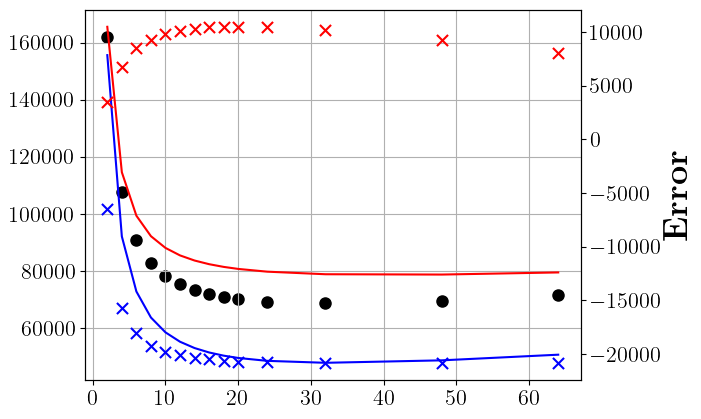

    epsilon           real      expected      rel_err
0         2  235953.000000  235215.34659  -737.653410
1         4  166232.333333  167345.63846  1113.305127
2         6  148108.333333  150282.50853  2174.175197
3         8  139701.000000  142496.88719  2795.887190
4        10  135074.666667  138240.60901  3165.942343
5        12  132408.666667  135699.68531  3291.018643
6        14  130521.000000  134119.62340  3598.623400
7        16  129344.000000  133131.29193  3787.291930
8        18  128661.666667  132533.19450  3871.527833
9        20  128330.666667  132205.65757  3874.990903
10       24  128153.666667  132086.29812  3932.631453
11       32  129048.666667  133034.70747  3986.040803
12       48  133379.333333  136867.49734  3488.164007
13       64  139038.333333  141658.48886  2620.155527


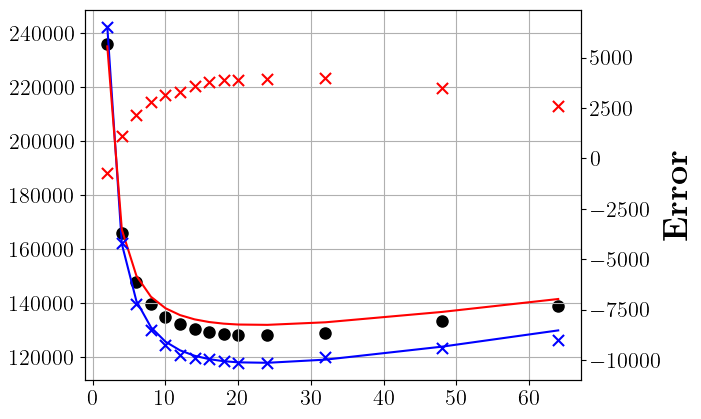

    epsilon           real      expected      rel_err
0         4  246528.666667  244753.71459 -1774.952077
1         6  213339.333333  212286.16668 -1053.166653
2         8  203142.666667  202797.59143  -345.075237
3        10  198089.000000  198115.82133    26.821330
4        12  195317.333333  195589.78929   272.455957
5        14  193542.333333  194230.88720   688.553867
6        16  192656.000000  193576.45426   920.454260
7        18  192246.000000  193379.64499  1133.644990
8        20  192201.333333  193496.64663  1295.313297
9        24  192784.333333  194345.87305  1561.539717
10       32  195382.000000  197389.59660  2007.596600
11       48  203278.000000  205605.55582  2327.555820
12       64  212510.000000  214827.19741  2317.197410


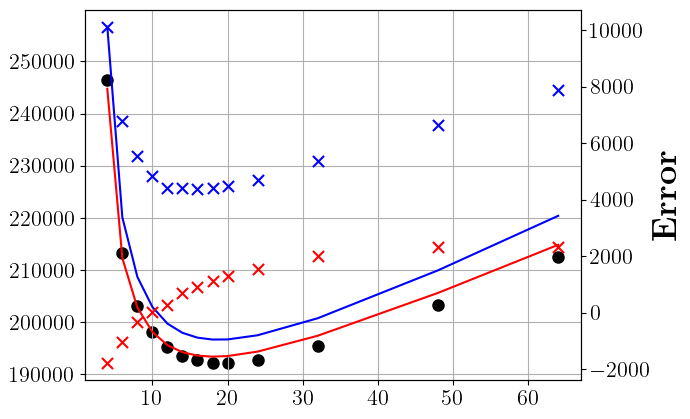

    epsilon           real      expected      rel_err
0         8  258063.333333  258147.98891    84.655577
1        10  239608.666667  239234.45084  -374.215827
2        12  234265.000000  234205.52274   -59.477260
3        14  231499.000000  231872.47965   373.479650
4        16  230085.333333  230786.67500   701.341667
5        18  229419.000000  230417.58908   998.589080
6        20  229216.333333  230506.81038  1290.477047
7        24  229966.666667  231536.84589  1570.179223
8        32  233023.666667  235371.81192  2348.145253
9        48  242501.000000  245743.92157  3242.921570
10       64  253511.666667  257230.82035  3719.153683


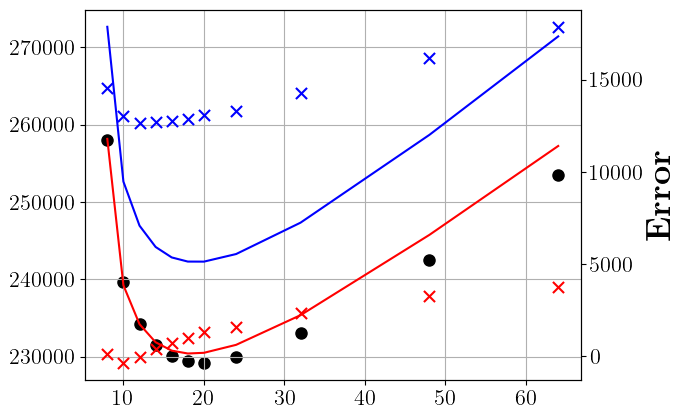

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

LOG_PATH = "/mnt/home/zwshi/learned-index/cost-model/visualize/data/log/"
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

def load_data(file_path,max_eps=64):
    df = pd.read_csv(file_path)
    grouped = df.groupby('epsilon', as_index=False)['avg_IOs'].mean()
    grouped = grouped.rename(columns={'avg_IOs': 'real'})
    grouped = grouped[grouped["epsilon"]<=max_eps] 
    return grouped

def load_log(log_file_path, M=20, query_nums=1e6, max_eps=64):
    df = pd.read_csv(log_file_path)
    df = df[df['M'] == M]
    grouped = df.groupby('epsilon', as_index=False)['cost'].mean()
    grouped['expected'] = grouped['cost'] * query_nums
    grouped = grouped[grouped["epsilon"] <= max_eps]
    return grouped[['epsilon', 'expected']] 

def prepare_merged(file_path, log_file_path, M=20, query_nums=1e6):
    real_df = load_data(file_path)
    # print(real_df)
    exp_df  = load_log(log_file_path, M, query_nums)
    # print(exp_df)
    merged = pd.merge(real_df, exp_df, on='epsilon', how='inner').sort_values('epsilon')
    # merged['rel_err'] = (merged['expected'] - merged['real']) / merged['real']
    merged['rel_err'] = (merged['expected'] - merged['real'])
    return merged

# === 新增：预计算全局 y 轴范围（左轴：IO；右轴：相对误差%）===
def compute_global_limits(tasks, log_file_path, query_nums=1e6, max_eps=64, pad_ratio=0.05):
    """
    tasks: [(csv_path, M), (csv_path, M), ...]
    返回： (y_io_min, y_io_max), (y_err_min_pct, y_err_max_pct)
    """
    io_min, io_max = float('inf'), float('-inf')
    err_min, err_max = float('inf'), float('-inf')
    for csv_path, M in tasks:
        merged = prepare_merged(csv_path, log_file_path, M, query_nums)
        if len(merged)==0: 
            continue
        # 左轴：真实/预测 IO
        cur_min = min(merged['real'].min(), merged['expected'].min())
        cur_max = max(merged['real'].max(), merged['expected'].max())
        io_min = min(io_min, cur_min)
        io_max = max(io_max, cur_max)
        # 右轴：相对误差（转百分比）
        cur_e_min = (merged['rel_err']*100).min()
        cur_e_max = (merged['rel_err']*100).max()
        err_min = min(err_min, cur_e_min)
        err_max = max(err_max, cur_e_max)
    # 加一点边距，避免顶边
    io_pad  = (io_max-io_min)*pad_ratio if np.isfinite(io_min) and np.isfinite(io_max) else 0
    err_pad = (err_max-err_min)*pad_ratio if np.isfinite(err_min) and np.isfinite(err_max) else 0
    return (io_min-io_pad, io_max+io_pad), (err_min-err_pad, err_max+err_pad)

def plot_data(file_path, log_file_path, revision_log_path, M=20, query_nums=1e6,
              y_io_lim=None, y_err_lim_pct=None):
    query_nums = query_nums * 0.7   # 70% evaluation
    merged = prepare_merged(file_path, log_file_path, M, query_nums)
    revi = prepare_merged(file_path, revision_log_path, M, query_nums)
    print(revi)
    fig, ax = plt.subplots()
    ax.scatter(merged['epsilon'], merged['real'], marker='o',
               label=r'\textbf{\Large{Real IOs}}', color="black")
    ax.plot(merged['epsilon'], merged['expected'], linestyle="-",
            label=r'\textbf{\Large{Estimated IOs}}', color="blue")
    ax.plot(revi['epsilon'], revi['expected'], linestyle="-",
            label=r'\textbf{\Large{Revised Estimated IOs}}', color="red")
    # ax.set_xlabel(r'\textbf{\Huge{Epsilon}}')
    # ax.set_ylabel(r'\textbf{\Huge{Total IOs}}')
    ax.grid(True)

    if y_io_lim is not None:
        ax.set_ylim(*y_io_lim)

    ax2 = ax.twinx()
    ax2.scatter(merged['epsilon'], merged['rel_err'],
                label=r'\textbf{\Large{Error}}', marker='x', color="blue")
    ax2.scatter(revi['epsilon'], revi['rel_err'],
                label=r'\textbf{\Large{Revised Error}}', marker='x', color="red")
    # ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.set_ylabel(r'\textbf{\Huge{Error}}')
    if y_err_lim_pct is not None:
        ax2.set_ylim(*y_err_lim_pct)

    # 合并图例
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    handles = lines + lines2
    labels = labels + labels2

    # 如果你不想在每幅图上显示 legend，可以把下面这行注释掉
    # ax.legend(handles, labels, loc='best')
    # plt.grid(True,'both',)
    plt.savefig(f"figs/books_{M}MB_IOs_prediction.pdf", dpi=300,
                bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close(fig)

    # 返回本图的 legend 信息
    return handles, labels

def save_legend_figure(handles, labels, filename="figs/IOs_prediction_legend.pdf"):
    # 这里可以按需要调节 figsize 和列数 ncol
    fig_legend = plt.figure(figsize=(8, 1.8))
    # frameon=False 去掉边框，方便丢到 Overleaf 里排版
    fig_legend.legend(handles, labels, loc='center', ncol=5, frameon=False)
    fig_legend.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig_legend)

# ===== 用法：先算全局范围，再按同一范围出图 =====
tasks = [
    ('books_10M_M40_falcon.csv', 40),
    ('books_10M_M20_falcon.csv', 20),
    ('books_10M_M10_falcon.csv', 10),
]
# y_io_lim, y_err_lim_pct = compute_global_limits(tasks, LOG_PATH + 'books_10M_uint64_unique.query.log')

# plot_data('books_10M_M30_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
#           LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 30)

handles, labels = plot_data('books_10M_M60_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 60)

plot_data('books_10M_M40_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 40)

plot_data('books_10M_M20_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 20)

plot_data('books_10M_M10_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 10)

save_legend_figure(handles, labels)




   epsilon          real      expected       rel_err
0        2  2.912915e+06  2.910970e+06  -1944.197967
1        4  1.896749e+06  1.902892e+06   6143.080733
2        8  1.390849e+06  1.402215e+06  11365.864533
3       12  1.224596e+06  1.236889e+06  12293.438400
4       16  1.141486e+06  1.155182e+06  13695.717900
5       20  1.092890e+06  1.106880e+06  13989.647300
6       24  1.060298e+06  1.075279e+06  14981.356900
7       32  1.021449e+06  1.037095e+06  15646.050467
8       48  9.883440e+05  1.002401e+06  14056.676900
9       64  9.762787e+05  9.884660e+05  12187.365733


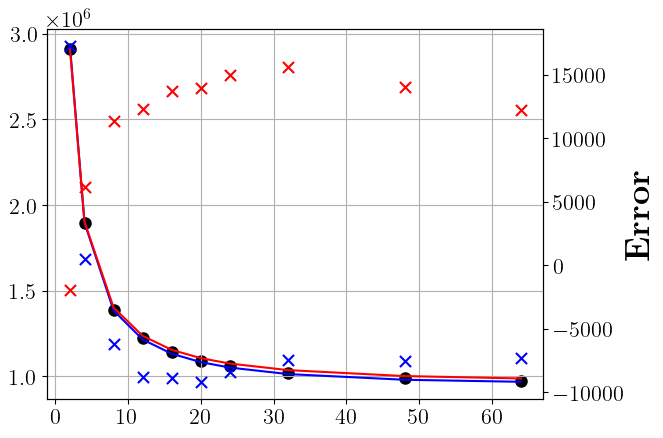

   epsilon          real      expected       rel_err
0        2  3.973252e+06  3.975556e+06   2303.708467
1        4  2.966072e+06  2.964778e+06  -1294.005633
2        8  2.461974e+06  2.464146e+06   2172.030500
3       12  2.296030e+06  2.300565e+06   4534.840833
4       16  2.216037e+06  2.221119e+06   5082.131000
5       20  2.168044e+06  2.175312e+06   7267.839400
6       24  2.137907e+06  2.146342e+06   8434.861167
7       32  2.102170e+06  2.113617e+06  11447.132900
8       48  2.077457e+06  2.090188e+06  12731.504733
9       64  2.075721e+06  2.087638e+06  11916.379667


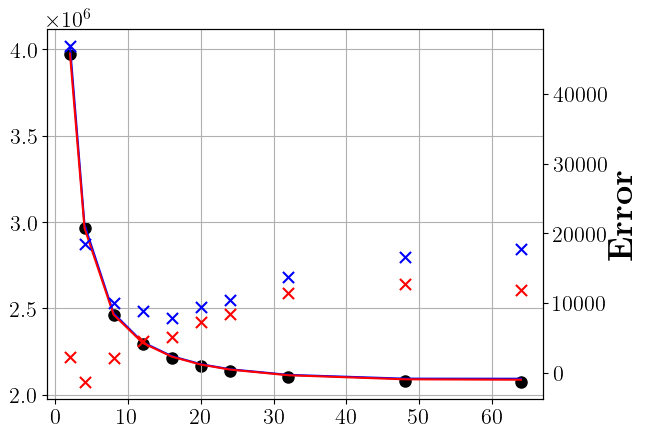

   epsilon          real      expected       rel_err
0        4  4.007296e+06  4.030947e+06  23651.615933
1        8  3.532746e+06  3.531308e+06  -1437.331567
2       12  3.371138e+06  3.369886e+06  -1251.403567
3       16  3.294580e+06  3.292934e+06  -1646.821633
4       20  3.251729e+06  3.249766e+06  -1963.525233
5       24  3.225071e+06  3.223525e+06  -1545.356067
6       32  3.197513e+06  3.196382e+06  -1131.033033
7       48  3.185379e+06  3.184336e+06  -1043.071933
8       64  3.195895e+06  3.193225e+06  -2670.055867


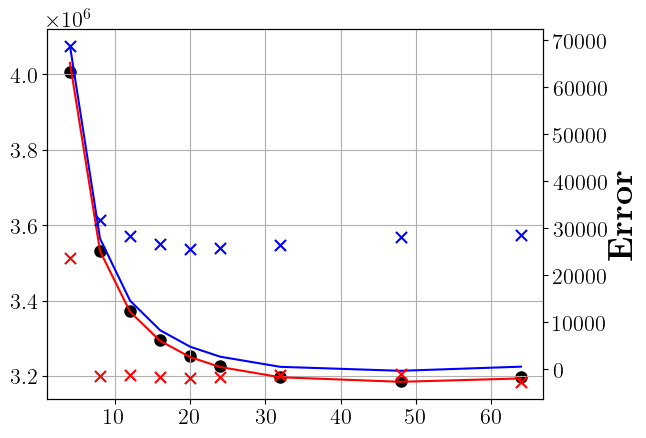

   epsilon          real      expected       rel_err
0        8  4.041419e+06  4.066294e+06  24875.269233
1       12  3.906686e+06  3.906027e+06   -658.639667
2       16  3.831742e+06  3.830360e+06  -1382.129033
3       20  3.789792e+06  3.788536e+06  -1256.076233
4       24  3.764438e+06  3.763676e+06   -762.224133
5       32  3.739671e+06  3.739343e+06   -328.063300
6       48  3.732790e+06  3.733005e+06    214.293767
7       64  3.748548e+06  3.747619e+06   -928.826800


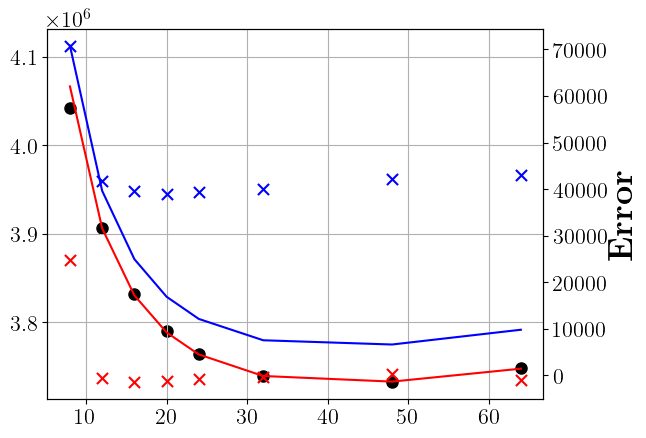

In [10]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

plot_data('range_fb_10M_M60.csv', LOG_PATH + 'fb_10M_uint64_unique.range.log',
          LOG_PATH + 'fb_10M_uint64_unique_revision.range.log',60)
plt.show()
plot_data('range_fb_10M_M40.csv', LOG_PATH + 'fb_10M_uint64_unique.range.log',
          LOG_PATH + 'fb_10M_uint64_unique_revision.range.log',40)
plt.show()
plot_data('range_fb_10M_M20.csv', LOG_PATH + 'fb_10M_uint64_unique.range.log',
          LOG_PATH + 'fb_10M_uint64_unique_revision.range.log',20)
plt.show()
plot_data('range_fb_10M_M10.csv', LOG_PATH + 'fb_10M_uint64_unique.range.log',
          LOG_PATH + 'fb_10M_uint64_unique_revision.range.log',10)
plt.show()

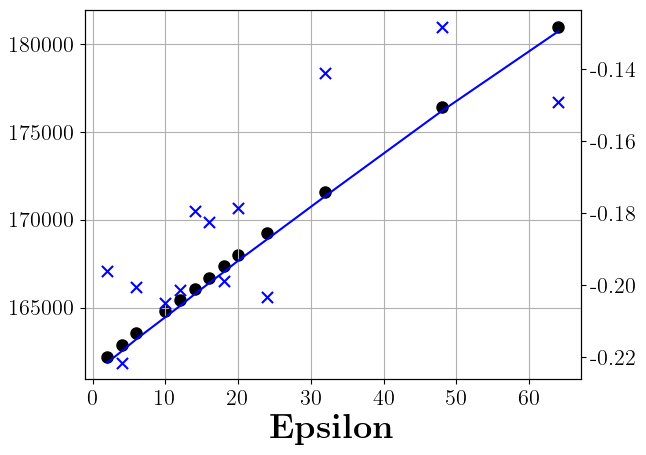

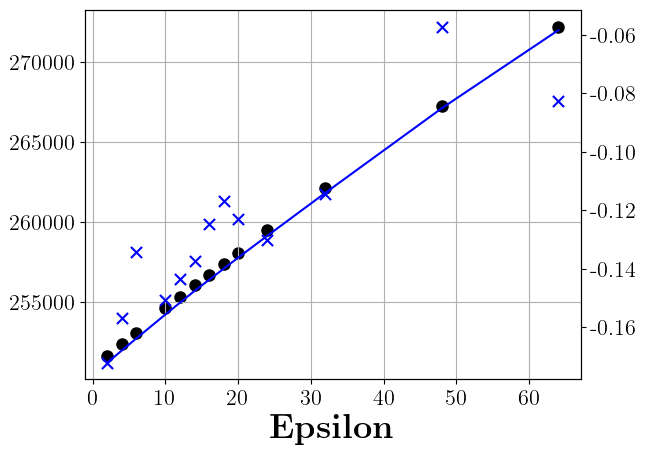

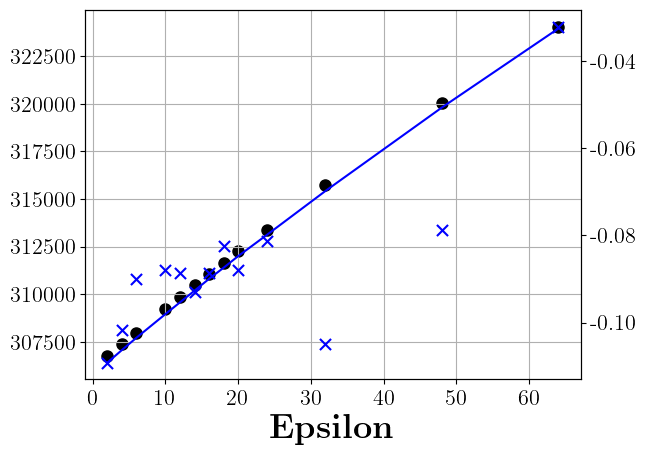

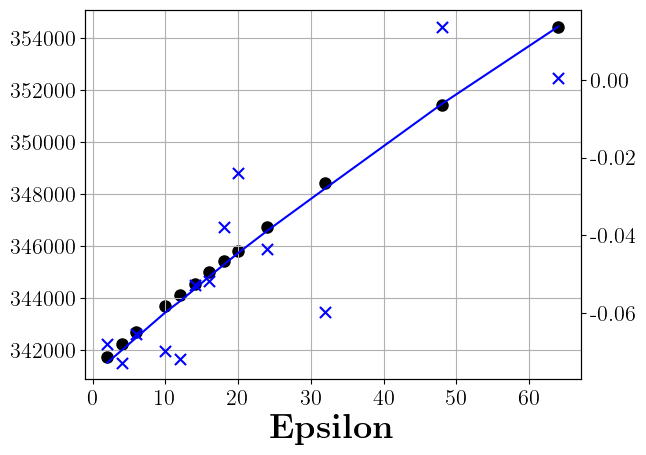

RuntimeError: latex was not able to process the following string:
b'\\\\textbf{\\\\Large{Relative Error(%)}}'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp60710s_i 90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a90945979e23d25f2448.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a90945979e23d25f2448.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a90945979e23d25f2448.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
)
Runaway argument?
{\Large {Relative Error(\end {document} 
! File ended while scanning use of \textbf .
<inserted text> 
                \par 
<*> ...d1c8baecc4b93404a13a90945979e23d25f2448.tex
                                                  
No pages of output.
Transcript written on tmp60710s_i/90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a
90945979e23d25f2448.log.




Error in callback <function _draw_all_if_interactive at 0x7c5453708220> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'\\\\textbf{\\\\Large{Relative Error(%)}}'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpdjkthiu1 90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a90945979e23d25f2448.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a90945979e23d25f2448.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a90945979e23d25f2448.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
)
Runaway argument?
{\Large {Relative Error(\end {document} 
! File ended while scanning use of \textbf .
<inserted text> 
                \par 
<*> ...d1c8baecc4b93404a13a90945979e23d25f2448.tex
                                                  
No pages of output.
Transcript written on tmpdjkthiu1/90e0d9ac70366208cc140c74ad1c8baecc4b93404a13a
90945979e23d25f2448.log.




<Figure size 800x180 with 0 Axes>

In [ ]:
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mticker
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

def plot_data(file_path, log_file_path, revision_log_path, M=20, query_nums=1e6,
              y_io_lim=None, y_err_lim_pct=None):
    merged = prepare_merged(file_path, log_file_path, M, query_nums)
    revi = prepare_merged(file_path, revision_log_path, M, query_nums)

    fig, ax = plt.subplots()
    ax.ticklabel_format(axis='y', style='plain', useOffset=False)
    
    ax.scatter(merged['epsilon'], merged['real'], marker='o',
               label=r'\textbf{\Large{Real IOs}}', color="black")
    ax.plot(merged['epsilon'], merged['expected'], linestyle="-",
            label=r'\textbf{\Large{Expected IOs}}', color="blue")
    # ax.plot(revi['epsilon'], revi['expected'], linestyle="-",
    #         label=r'\textbf{\Large{Revised Expected IOs}}', color="red")
    ax.set_xlabel(r'\textbf{\Huge{Epsilon}}')
    # ax.set_ylabel(r'\textbf{\Huge{Total IOs}}')
    ax.grid(True)

    if y_io_lim is not None:
        ax.set_ylim(*y_io_lim)

    ax2 = ax.twinx()
    ax2.ticklabel_format(axis='y', style='plain', useOffset=False)
    # ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=4))
    ax2.scatter(merged['epsilon'], merged['rel_err'] * 100,
                label=r'\textbf{\Large{Relative Error(%)}}', marker='x', color="blue")
    # ax2.scatter(revi['epsilon'], revi['rel_err'] * 1e6,
    #             label=r'\textbf{\Large{Revised Relative Error(ppm)}}', marker='x', color="red")
    # ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

    if y_err_lim_pct is not None:
        ax2.set_ylim(*y_err_lim_pct)

    # 合并图例
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    handles = lines + lines2
    labels = labels + labels2

    # 如果你不想在每幅图上显示 legend，可以把下面这行注释掉
    # ax.legend(handles, labels, loc='best')

    plt.savefig(f"books_256MB_{int(query_nums/1e6)}Mq_IOs_prediction.pdf", dpi=300,
                bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)

    # 返回本图的 legend 信息
    return handles, labels

handles,labels = plot_data('books-200M-1Mq-join.csv', LOG_PATH + 'books_200M_uint64_unique.1Mtable2.join.log',
          LOG_PATH + 'books_200M_uint64_unique_revision.1Mtable.join.log',256,query_nums=1e6)
plt.show()
plot_data('books-200M-2Mq-join.csv', LOG_PATH + 'books_200M_uint64_unique.2Mtable2.join.log',
          LOG_PATH + 'books_200M_uint64_unique_revision.2Mtable.join.log',256,query_nums=2e6)
plt.show()
plot_data('books-200M-3Mq-join.csv', LOG_PATH + 'books_200M_uint64_unique.3Mtable2.join.log',
          LOG_PATH + 'books_200M_uint64_unique_revision.3Mtable.join.log',256,query_nums=3e6)
plt.show()
plot_data('books-200M-4Mq-join.csv', LOG_PATH + 'books_200M_uint64_unique.4Mtable2.join.log',
          LOG_PATH + 'books_200M_uint64_unique_revision.4Mtable.join.log',256,query_nums=4e6)
plt.show()

# save_legend_figure(handles, labels)

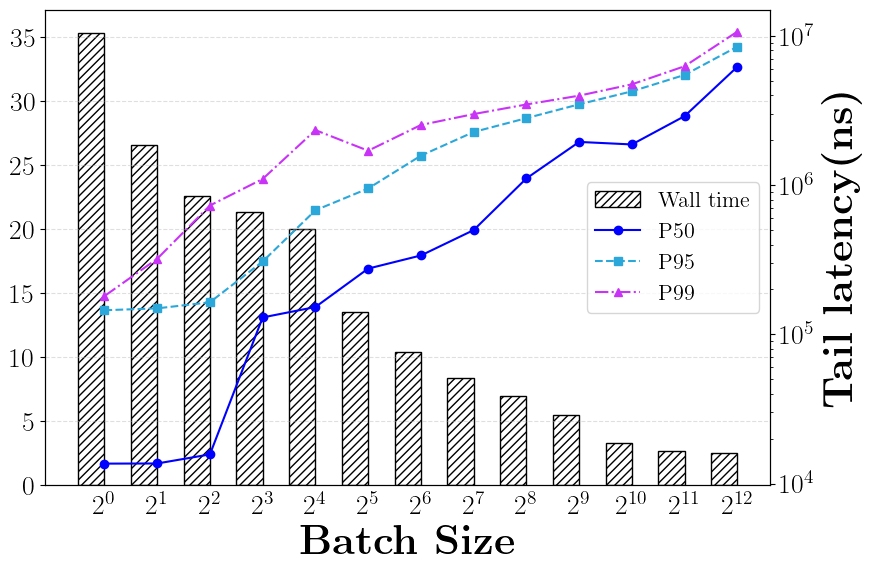

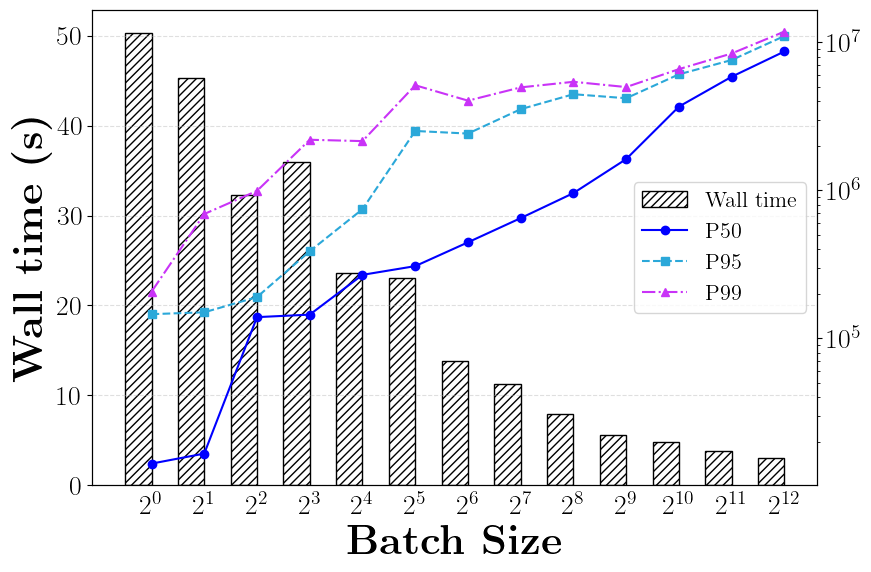

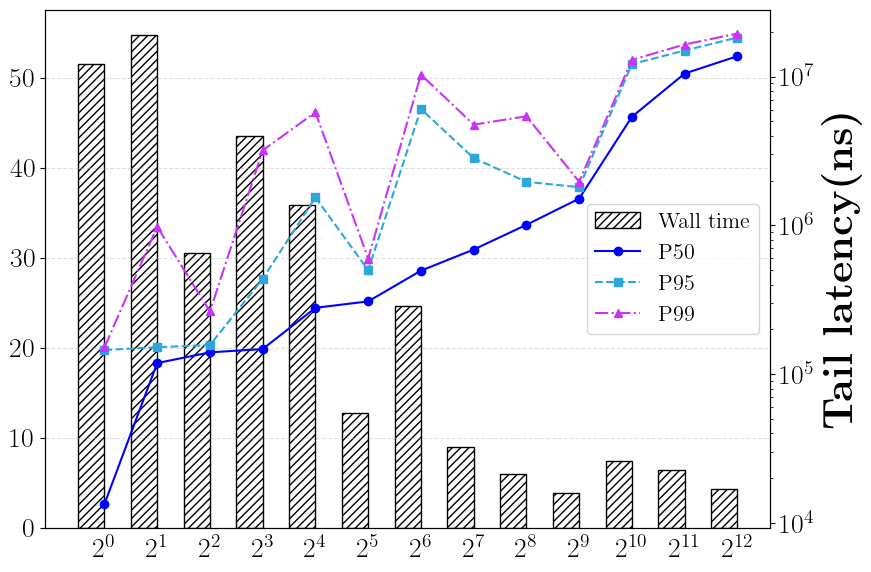

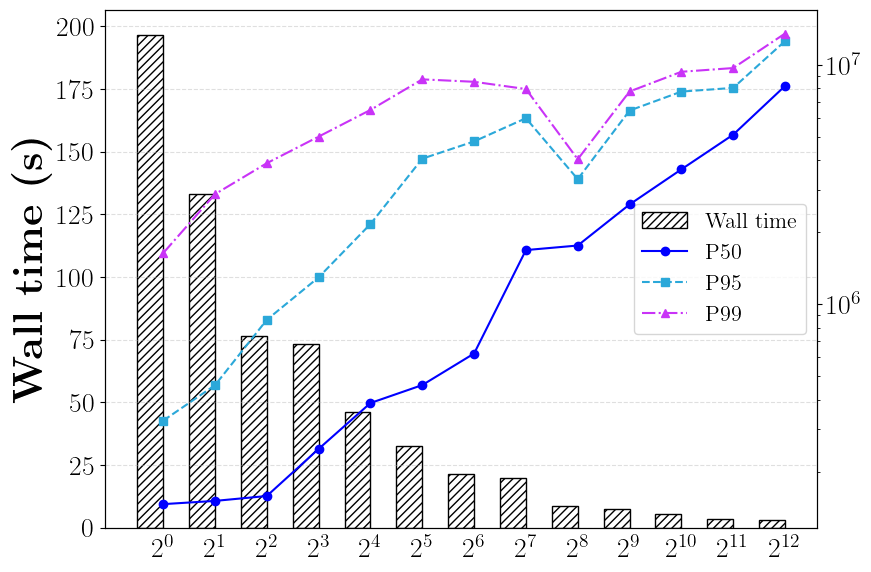

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

def load_data(file_path):
    df = pd.read_csv(file_path)
    grouped = df.groupby('batch', as_index=False).agg(
        avg_walltime_s=('avg_walltime_s', 'mean'),
        p50=('p50_ns', 'mean'),
        p95=('p95_ns', 'mean'),
        p99=('p99_ns', 'mean'),
    )
    grouped = grouped.sort_values('batch')
    return grouped

def plot_one_memory(file_path, mem_MB, out_prefix):
    data = load_data(file_path)

    fig, ax_left = plt.subplots(figsize=(9.0, 6.0))
    batch = data['batch'].values.astype(float)

    x = np.log2(batch)
    width = 0.5   

    bars = ax_left.bar(
        x - width / 2.0,      # 让柱子中心对齐到真实 batch 值
        data['avg_walltime_s'],
        width=width,
        color='none',         # 颜色样式你可以按论文风格再设计
        edgecolor='black',
        hatch='////',
        label='Wall time'
    )
    if mem_MB == 20 or mem_MB == 50:
        ax_left.set_xlabel(r'\textbf{Batch Size}',fontsize=30)
    if mem_MB == 0 or mem_MB == 20: 
        ax_left.set_ylabel(r'\textbf{Wall time (s)}',fontsize=30)
    exps = np.log2(batch)
    exps_rounded = np.round(exps).astype(int)
    ax_left.set_xticks(exps_rounded)
    ax_left.set_xticklabels(
        [rf'$2^{{{e}}}$' for e in exps_rounded]
    )
    ax_left.grid(True, axis='y', linestyle='--', alpha=0.4)

    # ---------- 右轴：tail latency 折线 ----------
    ax_right = ax_left.twinx()

    # 这里假定 p50/p95/p99 的单位和 magnitude 都差不多（比如秒或毫秒），
    # 如果是 ns，记得在 load_data 里先 /1e9 或在这里除。
    line_p50, = ax_right.plot(
        x, data['p50'],
        marker='o', linestyle='-', label='P50',
        color="blue",markersize=6
    )
    line_p95, = ax_right.plot(
        x, data['p95'],
        marker='s', linestyle='--', label='P95',
        color="#2ba8d9",markersize=6
    )
    line_p99, = ax_right.plot(
        x, data['p99'],
        marker='^', linestyle='-.', label='P99',
        color="#c933f7",markersize=6
    )
    if mem_MB == 10 or mem_MB == 50: 
        ax_right.set_ylabel(r'\textbf{Tail latency(ns)}',fontsize=30)
    # 如果跨度很大，可以打开下面这行用 log 轴
    ax_right.set_yscale('log',base=10)

    # ---------- 合并图例 ----------
    # 左轴只有一个 bar handle，右轴有 3 条线，把它们合到一起
    handles_left, labels_left = ax_left.get_legend_handles_labels()
    handles_right, labels_right = ax_right.get_legend_handles_labels()
    handles = handles_left + handles_right
    labels = labels_left + labels_right

    # ax_left.legend(handles, labels, loc='center left', bbox_to_anchor=(0.58, 0.35))
    ax_left.legend(handles, labels, loc='center right')

    # ax_left.set_title(rf'\textbf{{FALCON, Memory = {mem_MB}\,MB}}')
    ax_left.tick_params(axis='both', which='both', bottom=False, top=False, labelsize=20)
    ax_right.tick_params(axis='both', which='both', bottom=False, top=False, labelsize=20)
    fig.tight_layout()
    fig.savefig(f'{out_prefix}_{mem_MB}MB.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)

def plot_all_memories(file_paths, M_list):
    """
    file_paths: 每个 memory 对应一个 csv 文件
    M_list:     对应的 memory 大小 (MB)，例如 [20,10,0]
    """
    for file_path, mem_MB in zip(file_paths, M_list):
        # 输出文件前缀自己定一个
        plot_one_memory(file_path, mem_MB, out_prefix='batch_falcon_tail')

plot_all_memories(
    ['50M_batch_falcon.csv','20M_batch_falcon.csv','10M_batch_falcon.csv','0M_batch_falcon.csv'],
    [50, 20, 10, 0]
)


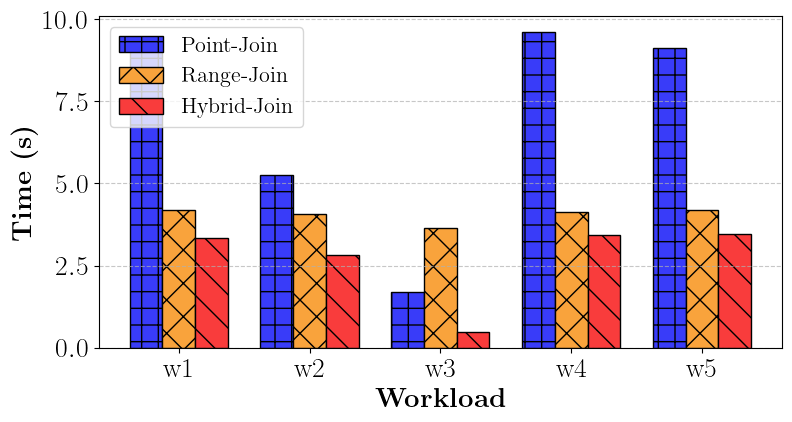

In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

# ========== 配置 ==========
DATADIR = "/mnt/home/zwshi/learned-index/cost-model/include/FALCON/results/log"      
PREFIX  = "books-200M"         # 文件前缀：books-200M-point2.csv 等
CONFS   = [1, 2, 3, 4, 5]       # 你收集的 conf 编号
STRATS  = ["point", "range", "join"]  # 三种策略的顺序（也决定绘图顺序）

STYLE = [dict(facecolor="#393cf9",hatch="+"),
         dict(facecolor="#f9a33c",hatch="x"),
         dict(facecolor="#f93c3c",hatch="\\")]
# 兼容你当前三个文件里出现过的两种列名写法
WALLTIME_COL_CANDIDATES = [
    "total_wall_time_s",
]

def aggregate_walltime(series: pd.Series) -> float:
    return float(series.mean())

def find_walltime_col(df: pd.DataFrame) -> str:
    for c in WALLTIME_COL_CANDIDATES:
        if c in df.columns:
            return c
    # 更宽松兜底：匹配 total + wall + time + s
    for c in df.columns:
        if re.search(r"total.*wall.*time.*s", c, re.IGNORECASE):
            return c
    raise KeyError(f"Cannot find wall-time column in {list(df.columns)}")

def load_one(prefix: str, strat: str, n: int) -> float:
    path = os.path.join(DATADIR, f"{prefix}-{strat}{n}.csv")
    df = pd.read_csv(path)
    col = find_walltime_col(df)
    return aggregate_walltime(df[col])

# ========== 收集数据：shape = (len(CONFS), len(STRATS)) ==========
data = np.full((len(CONFS), len(STRATS)), np.nan, dtype=float)

missing = []
for i, n in enumerate(CONFS):
    for j, strat in enumerate(STRATS):
        path = os.path.join(DATADIR, f"{PREFIX}-{strat}{n}.csv")
        if not os.path.exists(path):
            missing.append(path)
            continue
        data[i, j] = load_one(PREFIX, strat, n)

if missing:
    print("Warning: missing files:")
    for p in missing:
        print("  -", p)

# ========== 画图：grouped bars ==========
x = np.arange(len(CONFS))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 4.5))

offsets = {
    "point": -width,
    "range": 0.0,
    "join":  +width,
}

for j, start in enumerate(STRATS):
    if start == "point":
        lb = "Point-Join"
    elif start == "range":
        lb = "Range-Join"
    elif start == "join":
        lb = "Hybrid-Join"
    ax.bar(x + offsets[start], data[:, j], width=width, label=lb, edgecolor='black', 
           **STYLE[j])

ax.set_xticks(x)
ax.set_xticklabels([f"w{n}" for n in CONFS])
ax.set_ylabel(r"\textbf{Time (s)}",fontsize=20)
ax.set_xlabel(r"\textbf{Workload}",fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=20)
ax.legend(loc="upper left")

ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("./join.pdf")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16
    
def truncated_cmap(base_name="cividis", minval=0.05, maxval=0.75, n=256, reverse=False):
    base = mpl.cm.get_cmap(base_name, n)
    colors = base(np.linspace(minval, maxval, n))
    if reverse:
        colors = colors[::-1]  # 关键：反转截断后的颜色，而不是用 base_name+"_r" 再截断
    return mpl.colors.LinearSegmentedColormap.from_list(
        f"{base_name}_trunc_{minval:.2f}_{maxval:.2f}_{'r' if reverse else 'f'}",
        colors
    )
    
    
def heatmap_from_pivot(pivot: pd.DataFrame, title: str, outpath: Path, fmt=None, higher_is_better=True):
    """
    pivot: index=workers (y), columns=producers (x)
    """
    # Ensure numeric and sorted axes
    pivot = pivot.sort_index().sort_index(axis=1)

    x = pivot.columns.to_numpy()
    y = pivot.index.to_numpy()
    Z = pivot.to_numpy()

    cmap = "viridis"
    if higher_is_better:
        cmap = truncated_cmap(cmap, minval=0.0, maxval=1.0)
    else:
        cmap = truncated_cmap(cmap, minval=0.0, maxval=1.0, reverse=True)
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(Z, aspect="auto", origin="lower",cmap=cmap)

    # ax.set_title(title)
    ax.set_xlabel(r"\textbf{Producers (P)}",fontsize=30)
    ax.set_ylabel(r"\textbf{Workers (W)}",fontsize=30)

    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x)
    ax.set_yticks(np.arange(len(y)))
    ax.set_yticklabels(y)

    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(title, rotation=90, fontsize=30)

    # Optional: annotate each cell (useful for small grids like 5x8)
    # if fmt is not None:
    #     for i in range(len(y)):
    #         for j in range(len(x)):
    #             val = Z[i, j]
    #             if np.isfinite(val):
    #                 ax.text(j, i, fmt.format(val), ha="center", va="center", fontsize=12, color="white")

    fig.tight_layout()
    fig.show()
    fig.savefig(outpath, dpi=200)
    plt.close(fig)

def main(csv_path: str, out_dir: str = "figs_heatmap", agg="mean"):
    csv_path = Path(csv_path)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(csv_path)

    # 强制类型
    int_cols = ["producers", "workers"]
    for c in int_cols:
        df[c] = df[c].astype(int)

    # 你列名里 wall_time_ns 是 ns；有些行也可能写成 wall_time_s（若你后续改动）
    # 这里统一假设：wall_time_ns / data_IO_time_ns 都是纳秒
    # 如需兼容：可在此检查列是否存在。
    needed = ["latency_ns", "wall_time_ns", "hit_ratio", "data_IO_time_ns", "avg_IOs"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}")

    # 计算一个吞吐（QPS）：Q / wall_time_s
    # 注意：如果你不同 P 线程分到的 queries 数量一致，这样可比较；否则建议用实际 queries 数。
    # 这里用“每次运行总 queries 数”估算：同一 CSV 内应相同。
    # 若你想更稳妥，把 queries 总数写进 CSV。
    # 暂时取每条记录的 avg_IOs 不用于吞吐，吞吐仅依赖 wall_time.
    # 如果你每次运行的 queries 都一样，下面 OK。
    # 假设 queries 总数 = df.groupby(['baseline']).size()?? 不对。
    # 这里让你手动填写 queries_total（最稳妥）。
    queries_total = 1000000  # e.g., 1000000
    if queries_total is not None:
        df["throughput_qps"] = queries_total / (df["wall_time_ns"] * 1e-9)
    else:
        # 退化方案：画 1 / wall_time (越大越好)，当作相对吞吐指标
        df["throughput_rel"] = 1.0 / df["wall_time_ns"]

    # 聚合 repeats：按 (P,W) 聚合
    if agg == "median":
        g = df.groupby(["workers", "producers"], as_index=False).median(numeric_only=True)
    else:
        g = df.groupby(["workers", "producers"], as_index=False).mean(numeric_only=True)

    # 1) Wall time heatmap（秒）
    wall_pivot = g.pivot(index="workers", columns="producers", values="wall_time_ns") / 1e9
    heatmap_from_pivot(
        wall_pivot,
        title=r"\textbf{Wall Time (s)}",
        outpath=out_dir / "heatmap_wall_time_s.pdf",
        fmt="{:.2f}"
    )

    # 2) Avg latency heatmap（ms）
    lat_pivot = g.pivot(index="workers", columns="producers", values="latency_ns") / 1e6
    heatmap_from_pivot(
        lat_pivot,
        title=r"\textbf{Query Latency (ms)}",
        outpath=out_dir / "heatmap_latency_ms.pdf",
        fmt="{:.2f}",
        higher_is_better=False
    )

    # 3) Hit ratio heatmap
    # hit_pivot = g.pivot(index="workers", columns="producers", values="hit_ratio")
    # heatmap_from_pivot(
    #     hit_pivot,
    #     title="Cache Hit Ratio",
    #     outpath=out_dir / "heatmap_hit_ratio.png",
    #     fmt="{:.2f}"
    # )

    # 4) Data IO time heatmap（秒）
    # io_pivot = g.pivot(index="workers", columns="producers", values="data_IO_time_ns") / 1e9
    # heatmap_from_pivot(
    #     io_pivot,
    #     title="Data I/O Time (s)",
    #     outpath=out_dir / "heatmap_data_io_time_s.png",
    #     fmt="{:.2f}"
    # )

    # 5) Throughput heatmap（相对：1/wall_time）
    if "throughput_qps" in g.columns:
        thr_pivot = g.pivot(index="workers", columns="producers", values="throughput_qps")
        heatmap_from_pivot(
            thr_pivot,
            title=r"\textbf{Throughput (QPS)}",
            outpath=out_dir / "heatmap_throughput_qps.pdf",
            fmt="{:.0f}"
        )
    else:
        thr_pivot = g.pivot(index="workers", columns="producers", values="throughput_rel")
        heatmap_from_pivot(
            thr_pivot,
            title="Relative Throughput (1 / wall_time_ns)",
            outpath=out_dir / "heatmap_throughput_rel.pdf",
            fmt="{:.2e}"
        )

    print(f"Saved heatmaps to: {out_dir.resolve()}")

main("./books_200M_uint64_unique_falcon_grid2.csv","./","mean")



/tmp/ipykernel_52477/750851740.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(base_name, n)
/tmp/ipykernel_52477/750851740.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(base_name, n)


Saved heatmaps to: /mnt/home/zwshi/learned-index/cost-model/include/FALCON/results/log


/tmp/ipykernel_52477/750851740.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(base_name, n)


epsilon     4         16        64        256       1024      4096      16384  \
threads                                                                         
1        0.978948  0.938566  0.998403  1.074584  1.391594  1.789116  3.191013   
4        0.995011  0.999669  0.989635  1.067055  1.383339  2.094711  4.781814   
16       1.015437  1.012984  1.017154  1.055683  1.085337  1.017416  2.389453   
64       0.949420  1.065643  1.036794  0.972951  1.001139  0.902525  1.485358   
256      1.034111  1.057752  0.938671  1.056934  1.059077  0.937634  1.173039   

epsilon     65536  
threads            
1        1.958982  
4        5.160005  
16       2.665851  
64       1.279737  
256      0.958922  


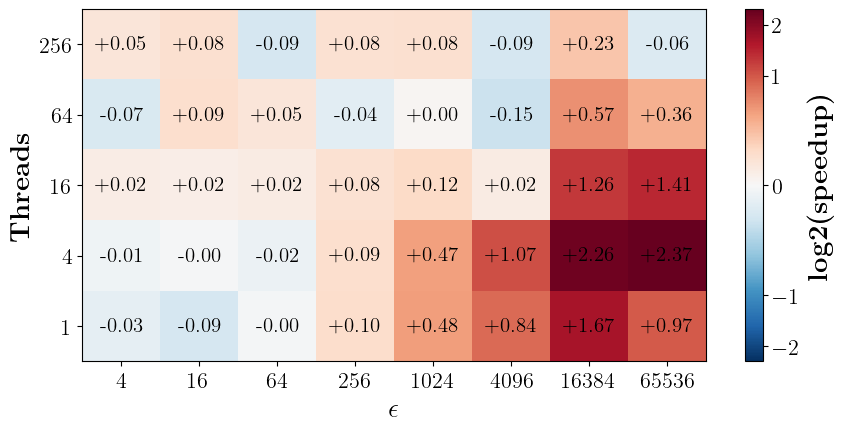

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm,SymLogNorm,FuncNorm

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16
# -----------------------------
# Input data (from your table)
# -----------------------------
speedup_by_eps = {
    4: {
        1:   0.978947685,
        4:   0.995011151,
        16:  1.015437423,
        64:  0.949420297,
        256: 1.034110879,
    },
    16: {
        1:   0.938566401,
        4:   0.999669008,
        16:  1.012983985,
        64:  1.065643157,
        256: 1.057751552,
    },
    64: {
        1:   0.998403308,
        4:   0.989634904,
        16:  1.017153905,
        64:  1.036794195,
        256: 0.938671465,
    },
    256: {
        1:   1.07458416,
        4:   1.067055186,
        16:  1.055683412,
        64:  0.972951394,
        256: 1.056933598,
    },
    1024: {
        1:   1.391594012,
        4:   1.383339233,
        16:  1.085337057,
        64:  1.00113907,
        256: 1.05907693,
    },
    4096: {
        1:   1.789116185,
        4:   2.094711033,
        16:  1.017416164,
        64:  0.902525443,
        256: 0.937634357,
    },
    16384: {
        1:   3.191012859,
        4:   4.781814015,
        16:  2.389452827,
        64:  1.485357749,
        256: 1.173039249,
    },
    65536: {
        1:   1.958982214,
        4:   5.160004959,
        16:  2.665851494,
        64:  1.279736753,
        256: 0.958922183,
    },
}

# -----------------------------
# 2) Build pivot table: rows=threads, cols=epsilon
# -----------------------------
threads = sorted({t for eps in speedup_by_eps for t in speedup_by_eps[eps].keys()})
epsilons = sorted(speedup_by_eps.keys())

speedup = pd.DataFrame(
    [[speedup_by_eps[eps].get(t, np.nan) for eps in epsilons] for t in threads],
    index=threads,
    columns=epsilons,
)
speedup.index.name = "threads"
speedup.columns.name = "epsilon"

print(speedup)

# -----------------------------
# 3) Plot speedup heatmap (centered at 1.0)
# -----------------------------
Z = speedup.to_numpy()
# vmin, vmax = np.nanmin(Z), np.nanmax(Z)
# norm = TwoSlopeNorm(vmin=vmin, vcenter=1.0, vmax=vmax)

# fig, ax = plt.subplots(figsize=(9.0, 4.6))
# im = ax.imshow(Z, origin="lower", aspect="auto", cmap="RdBu_r", norm=norm)

# ax.set_xticks(np.arange(len(epsilons)))
# ax.set_xticklabels(epsilons)
# ax.set_yticks(np.arange(len(threads)))
# ax.set_yticklabels(threads)

# ax.set_xlabel(r"$\epsilon$")
# ax.set_ylabel("threads")
# ax.set_title("Speedup heatmap (all-at-once / one-by-one)")

# # annotate cells
# for i in range(len(threads)):
#     for j in range(len(epsilons)):
#         val = Z[i, j]
#         if np.isfinite(val):
#             ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)

# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label("Speedup (×), centered at 1.0")

# fig.tight_layout()
# fig.savefig("speedup_heatmap.png", dpi=220, bbox_inches="tight")
# plt.show()

# -----------------------------
# 4) (Optional but recommended) log2(speedup) heatmap
#    Better when speedup spans wide range (e.g., up to 5×)
# -----------------------------
logZ = np.log2(Z)
max_abs = np.nanmax(np.abs(logZ))
# vmin2, vmax2 = np.nanmin(logZ), np.nanmax(logZ)
# norm2 = TwoSlopeNorm(vmin=-max_abs, vcenter=0.0, vmax=max_abs)
gamma = 0.55  # 0.4~0.8 之间常用；越小越强调0附近、越压缩极端

def forward(x):
    x = np.asarray(x)
    return np.sign(x) * (np.abs(x) / max_abs) ** gamma

def inverse(y):
    y = np.asarray(y)
    return np.sign(y) * (np.abs(y) ** (1 / gamma)) * max_abs

norm2 = FuncNorm((forward, inverse), vmin=-max_abs, vmax=max_abs)

fig, ax = plt.subplots(figsize=(9.0, 4.6))
im = ax.imshow(logZ, origin="lower", aspect="auto", cmap="RdBu_r", norm=norm2)

ax.set_xticks(np.arange(len(epsilons)))
ax.set_xticklabels(epsilons)
ax.set_yticks(np.arange(len(threads)))
ax.set_yticklabels(threads)

ax.set_xlabel(r"\textbf{$\epsilon$}",fontsize=20)
ax.set_ylabel(r"\textbf{Threads}",fontsize=20)
# ax.set_title("log2(Speedup) heatmap (0 = no gain)")

for i in range(len(threads)):
    for j in range(len(epsilons)):
        val = logZ[i, j]
        if np.isfinite(val):
            ax.text(j, i, f"{val:+.2f}", ha="center", va="center", fontsize=15)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"\textbf{log2(speedup)}",fontsize=20)

fig.tight_layout()
fig.savefig("speedup_log2_heatmap.pdf", dpi=220, bbox_inches="tight")
plt.show()